# TRAWLING4PACE 
## Fish-PACE Hackweek 1/26/26-1/30/26
**Project members:** 
* Mary Kate Munley
* Justine Whitaker
* Victoria Abunaw
* Punya Puthukulangara
* Frederic Bonou
* Leandro Machado Cruz
* Haley Synan <br>

**Research question:** Can PACE data be used as predictors for catch abundance for Silver Hake in the NorthWest Atlantic? Which models are the best predictors? <br>
**Datasets**:
* NOAA NEFSC Bottom Trawl Survey Data (Spring 2024, Fall 2024, Spring 2025)
* PACE Rrs
* GLORYS modeled datasets
* AVISO FSLE
* Copernicus wind stress curl




## Table of contents
*Note: If you are working in a jupyter environment with this notebook downloaded, this TOC is interactive. However, it is not interactive on the github webpage*
#### 1. [Load data](#load_data)
#### 2. [Data cleaning](#clean_data)
#### 3. [Split data](#split_data)
#### 4. [Model training](#model_training)
#### &emsp; 4a. [Random forest](#rf)
#### &emsp;&emsp; 4aa. [Hyper-parameterization](#rf_hp)
#### &emsp;&emsp; 4ab. [Final modeling training](#rf_fm)
#### &emsp;&emsp; 4ac. [Feature importance](#rf_fi)
#### &emsp;&emsp; 4ad. [Predict catch abundance](#rf_pa)
#### &emsp; 4b. [Boosted regression tree](#brt)
#### &emsp;&emsp; 4ba. [Hyper-parameterization](#brt_hp)
#### &emsp;&emsp; 4bb. [Final modeling training](#brt_fm)
#### &emsp;&emsp; 4bc. [Feature importance](#brt_fi)
#### &emsp;&emsp; 4bd. [Predict catch abundance](#brt_pa)
#### 5. [Interpret results](#ir)
#### &emsp; 5a. [Partial depedence plots](#ppd)
#### &emsp;&emsp; 5aa. [Random Forest](#ppd_rf)
#### &emsp;&emsp; 5ab. [Boosted Regression Tree](#ppd_brt)
#### &emsp; 5b. [Bland Altman plots](#ba)
#### 6. [Visualize results](#vr)
#### &emsp; 6a. [Mapped abundance predictions](#mar)
#### &emsp; 6b. [Mapped Residuals](#mr)
#### 7. [Statistical Analysis](#sa)
#### 8. [Conclusions](#conc)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import datetime
import numpy as np
import cartopy
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import cartopy
from sklearn.inspection import PartialDependenceDisplay


## Load data <a id="load_data"></a>

The fish catch data we are using for this project is the NOAA NEFSC Bottom Trawl Survey Data. We are only using the surveys that coincide with the PACE timeline, Spring 2024, Fall 2024, and Spring 2025. 
For remotely-sensed data, we are using matched Rrs (L3m) data from PACE, wind stress curl from Copernicus, and FSLE from Aviso. <br>
Note: the match-up code is not shown in this notebook, but can be found in ```/2026-proj-Trawling4PACE/contributer_folders/leandro/download_*.ipynb``` for the non-PACE remotely-sensed variables. Match-up code demonstrated in the [Match-up basics - Points and PACE](https://fish-pace.github.io/hackweek-2025/presentations/notebooks/matchups.html) tutorial were adapted for our catch data. 


In [27]:
# LOAD DATA
# ---------------------------------------------------
df= pd.read_csv('/home/jovyan/2026-proj-Trawling4PACE/data/Test_PACE_RRS_AVW_CHL_1D_centerpixel.csv') #open matched PACE data
df =df[df.SCIENTIFIC_NAME=='Merluccius bilinearis (silver hake)'] #filter only silver hake catch data
df=df.dropna(subset=['avw_0','chlor_a_0']) #filter out nans
df1= pd.read_csv('/home/jovyan/2026-proj-Trawling4PACE/contributor_folders/leandro/correlation_data.csv') #open matched copernicus/AVISO data 

#check duplicates
df.groupby(['DECDEG_ENDLAT','DECDEG_ENDLON']).size().sort_values(ascending=False).head()
df1.groupby(['DECDEG_ENDLAT','DECDEG_ENDLON']).size().sort_values(ascending=False).head()
#Diagnose near duplicate rows values
df[['DECDEG_ENDLAT','DECDEG_ENDLON']].nunique()
#Select numeric columns explicitly
num_cols = df.select_dtypes(include='number').columns
num_cols1 = df1.select_dtypes(include='number').columns
#Aggregate
df1_agg = (
    df
    .groupby(['DECDEG_ENDLAT', 'DECDEG_ENDLON','BEGIN_GMT_TOWDATE'], as_index=False)[num_cols]
    .mean()
)

df2_agg = (
    df1
    .groupby(['DECDEG_ENDLAT', 'DECDEG_ENDLON','BEGIN_GMT_TOWDATE'], as_index=False)[num_cols1]
    .mean()
)

# Merge
df= pd.merge(df1_agg, df2_agg, on=['DECDEG_ENDLAT','DECDEG_ENDLON','BEGIN_GMT_TOWDATE']) #merge dataframes together based on station (ie lat/lon/time)
df=df.rename(columns={'SURFTEMP_x':'SURFTEMP', 'SURFSALIN_x':'SURFSALIN', 'BOTTEMP_x':'BOTTEMP', 'BOTSALIN_x':'BOTSALIN'}) #rename columns as necessary 

## Data cleaning  <a id="clean_data"></a>
Here we need to split the datetime string into day, month, year, and day of year (doy). Note because we are training a random forest we don't need to scale the data. 

In [28]:
# FEATURE ENGINEERING (DATE)
# ---------------------------------------------------
df['BEGIN_GMT_TOWDATE'] = pd.to_datetime(df['BEGIN_GMT_TOWDATE'])

df['month'] = df['BEGIN_GMT_TOWDATE'].dt.month
df['day']   = df['BEGIN_GMT_TOWDATE'].dt.day
df['year']  = df['BEGIN_GMT_TOWDATE'].dt.year
df['doy']   = df['BEGIN_GMT_TOWDATE'].dt.dayofyear
df['EXPCATCHNUM_log'] = np.log10(df.EXPCATCHNUM)

In [29]:
# FEATURE SELECTION 
## Because there are so many columns in the merged dataset, its easier to choose the ones we want to use rather than drop the ones we dont
cols = list(df.filter(like="Rrs").columns) #grab all Rrs
#grab other chosen features
cols.append('BOTTEMP')
cols.append('BOTSALIN')
cols.append('DECDEG_ENDLAT') 
cols.append('DECDEG_ENDLON')
cols.append('MAXDEPTH')
cols.append('year')
cols.append('doy')
cols.append('fsle_fsle_max')
cols.append('curl_stress_curl')

#add response variable to the list (for now) 
cols.append('EXPCATCHNUM_log')

# CLEAN DATA
# ---------------------------------------------------
df = df[cols]

# REMOVE NaN TARGETS (CRITICAL)
df = df.dropna(subset=['EXPCATCHNUM_log'])
df = df.replace([np.inf, -np.inf], 0)

In [30]:
# DEFINE FEATURES & TARGET
# ---------------------------------------------------
y = df['EXPCATCHNUM_log']
cols.remove('EXPCATCHNUM_log') #remove the response variable from the list before using it to define the predictor variables
#X = df[cols]
#note we had previously run this on all Rrs and chose the 10 most important Rrs wavelengths to use here in the final model
X = df[['Rrs_558','Rrs_563','Rrs_371','Rrs_373','Rrs_573','Rrs_578','Rrs_550','Rrs_570','Rrs_717','Rrs_395','BOTTEMP',
 'BOTSALIN',
 'DECDEG_ENDLAT',
 'DECDEG_ENDLON',
 'MAXDEPTH',
 'year',
 'doy','fsle_fsle_max','curl_stress_curl'
        
]]

## Split data <a id="split_data"></a>

We are predicting species abundance (catch number) and using other variables from the in-situ data and PACE as predictors. We then split the data into 80% as training data and 20% as testing data. <br>
NOTE: we are doing a random split here, but this is not the best way to split it. Instead, we should be splitting temporally (see our presentation for details on why). But due to lack of time, we are doing a random split here

In [31]:
# TRAIN / TEST SPLIT
# ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [32]:
# KNN IMPUTATION (FIT ON TRAIN ONLY)
# ---------------------------------------------------
imputer = KNNImputer(
    n_neighbors=5,
    weights='distance'
)

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imputed = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

## Model training! <a id="model_training"></a>
Here we are comparing the output from two different models: a random forest (using [sklearn](https://scikit-learn.org/stable/)) and boosted regression tree (using [xgboost](https://xgboost.readthedocs.io/en/stable/)). 
## **Random forest** <a id="rf"></a>
### Hyperparameterization <a id="rf_hp"></a>
We are going to optimize 3 parameters: n_estimators, max_features, and max_depth
*Note: definitions are taken from results of a google search of random forest parameters* 
* n_estimators: number of decision trees
* max_features: controls the maximum number of features that are randomly considered at each node when the tree is looking for the best split
* max_depth: controls the maximum depth of each individual decision tree in the forest
* oob_score: out of bag estimate of models general error
* random_state: for reproducibility

In [33]:
# HYPERPARAMETER GRID
# ---------------------------------------------------
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2', 0.8],
    'max_depth': [10, 20, 30, None]
}

rf = RandomForestRegressor(
    random_state=0,
    oob_score=True,
    bootstrap=True
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# FIT GRID SEARCH
# ---------------------------------------------------
grid_search.fit(X_train_imputed, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV neg-MSE:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 300}
Best CV neg-MSE: -0.5008667524563714


### Train the final Random forest model based on results from the hyper-parameterization <a id="rf_fm"></a>

In [34]:
# FINAL MODEL
# ---------------------------------------------------
best_rf = RandomForestRegressor(
    **grid_search.best_params_,
    random_state=0,
    bootstrap=True,
    oob_score=True
)
best_rf.fit(X_train_imputed, y_train)

# EVALUATION
# ---------------------------------------------------
print(f"Out-of-Bag Score: {best_rf.oob_score_}")

Out-of-Bag Score: 0.5051169397665014


### Check feature importance <a id="rf_fi"></a>

In [36]:
importances = best_rf.feature_importances_

feature_imp_df = (
    pd.DataFrame({
        'Feature': X_train.columns,
        'Gini Importance': importances
    })
    .sort_values('Gini Importance', ascending=False)
)

print(feature_imp_df)

             Feature  Gini Importance
14          MAXDEPTH         0.134667
11          BOTSALIN         0.117288
13     DECDEG_ENDLON         0.109467
16               doy         0.080294
12     DECDEG_ENDLAT         0.073436
10           BOTTEMP         0.068933
2            Rrs_371         0.050116
3            Rrs_373         0.049027
9            Rrs_395         0.046666
17     fsle_fsle_max         0.037034
6            Rrs_550         0.031827
8            Rrs_717         0.031277
7            Rrs_570         0.027144
4            Rrs_573         0.026423
5            Rrs_578         0.025312
0            Rrs_558         0.024747
18  curl_stress_curl         0.023262
1            Rrs_563         0.022986
15              year         0.020095


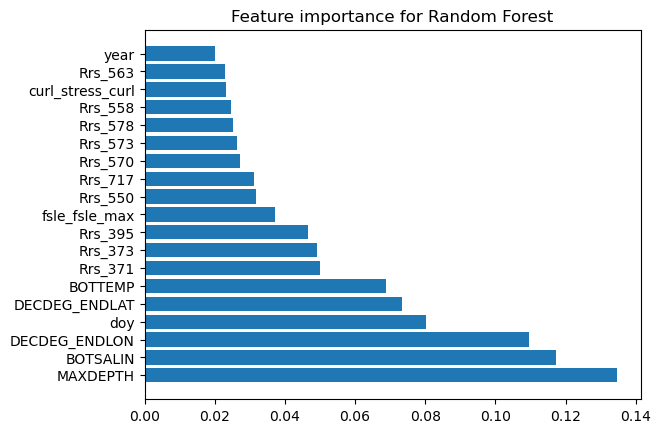

In [37]:
plt.barh(feature_imp_df.Feature, feature_imp_df['Gini Importance'])
plt.title('Feature importance for Random Forest')
plt.savefig('/home/jovyan/2026-proj-Trawling4PACE/figures/RF_feature_importance.jpg')

### Predict silver hake abundances <a id="rf_pa"></a>
And calculate performance metrics

In [ ]:
#Prediction
predictions = best_rf.predict(X_test_imputed)
#print R2 & MSE
mse = mean_squared_error(y_test, predictions)
r2  = r2_score(y_test, predictions)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

## **Boosted regression tree** <a id="brt"></a>
### Hyperparameterization <a id="brt_hp"></a>
We are going to optimize 5 parameters: n_estimators, learning rate, max_depth, reg_alpha, and reg_lambda. <br>
*Note: definitions are taken from results of a google search of xgboost parameters* 
* n_estimators: number of decision trees
* max_depth: controls the maximum depth of each individual decision tree in the forest
* learning rate: controls the contribution of each individual tree to the final ensemble prediction
* reg_alpha: adds a penalty proportional to the absolute value of the leaf weights. Increasing its value encourages sparsity, meaning it pushes the weights of less important features or branches toward zero. This can lead to simpler and more generalizable models. The default value is 0, which means no L1 regularization is applied by default.
* reg_lambda: controls the L2 regularization term on the weights (scores) of the leaf nodes in the boosted regression trees


In [39]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 8, 10],
    'reg_alpha': [0.0, 0.01, 0.05, 0.1],
    'reg_lambda': [0.1, 1, 2]
}

xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_imputed, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV neg-MSE:", grid_search.best_score_)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.05, 'reg_lambda': 1}
Best CV neg-MSE: -0.5428787379440001


### Train the final Boosted regression tree model based on results from the hyper-parameterization <a id="brt_fm"></a>

xgb_reg = xgb.XGBRegressor(
    **grid_search.best_params_,
    objective='reg:squarederror',
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

xgb_reg.fit(X_train_imputed, y_train)

print("Model training complete.")

### Check feature importance <a id="brt_fi"></a>

In [ ]:
# Get feature importances as a numpy array
importances = xgb_reg.feature_importances_
feature_names = X_train.columns # Get feature names if X_train is a pandas DataFrame

# Create a pandas DataFrame for a clear, sortable list
xgb_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort and print the results
xgb_feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

plt.barh(feature_imp_df.Feature, feature_imp_df['Gini Importance'])
plt.title('Feature importance for Boosted Regression Tree')
plt.savefig('/home/jovyan/2026-proj-Trawling4PACE/figures/BRT_feature_importance.jpg')

### Predict silver hake abundances <a id="brt_pa"></a>
And calculate performance metrics

In [41]:
predictions_brt = xgb_reg.predict(X_test_imputed)

rmse = np.sqrt(mean_squared_error(y_test, predictions_brt))
r2 = r2_score(y_test, predictions_brt)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test R²: {r2:.4f}")

Test RMSE: 0.7746
Test R²: 0.4988


## Interpret results <a id="ir"></a>
### Partial dependence plots <a id="ppd"></a>
How to interpret: <br>
Partial dependence plots isolate the effect of one variable on the model's output. The single variable is on the x-axis, and the model's predicted catch at each value of that variable averaged over all other predictors in the dataset is on the y-axis. <br>
* If the PPD line is flat: the variable has no meaningful effect on the catch
* If the PPD line increases/decreases consistently: there is a consistent relationship between the variable and predicted catch (ie increased temperature = increased catch)
* Hump-shaped curve: there is an optimal range at for catch
* Noisy line: the predictor is weak, there isn't enough data, or the model is overfitting 

#### PPD: Random Forest <a id="ppd_rf"></a>

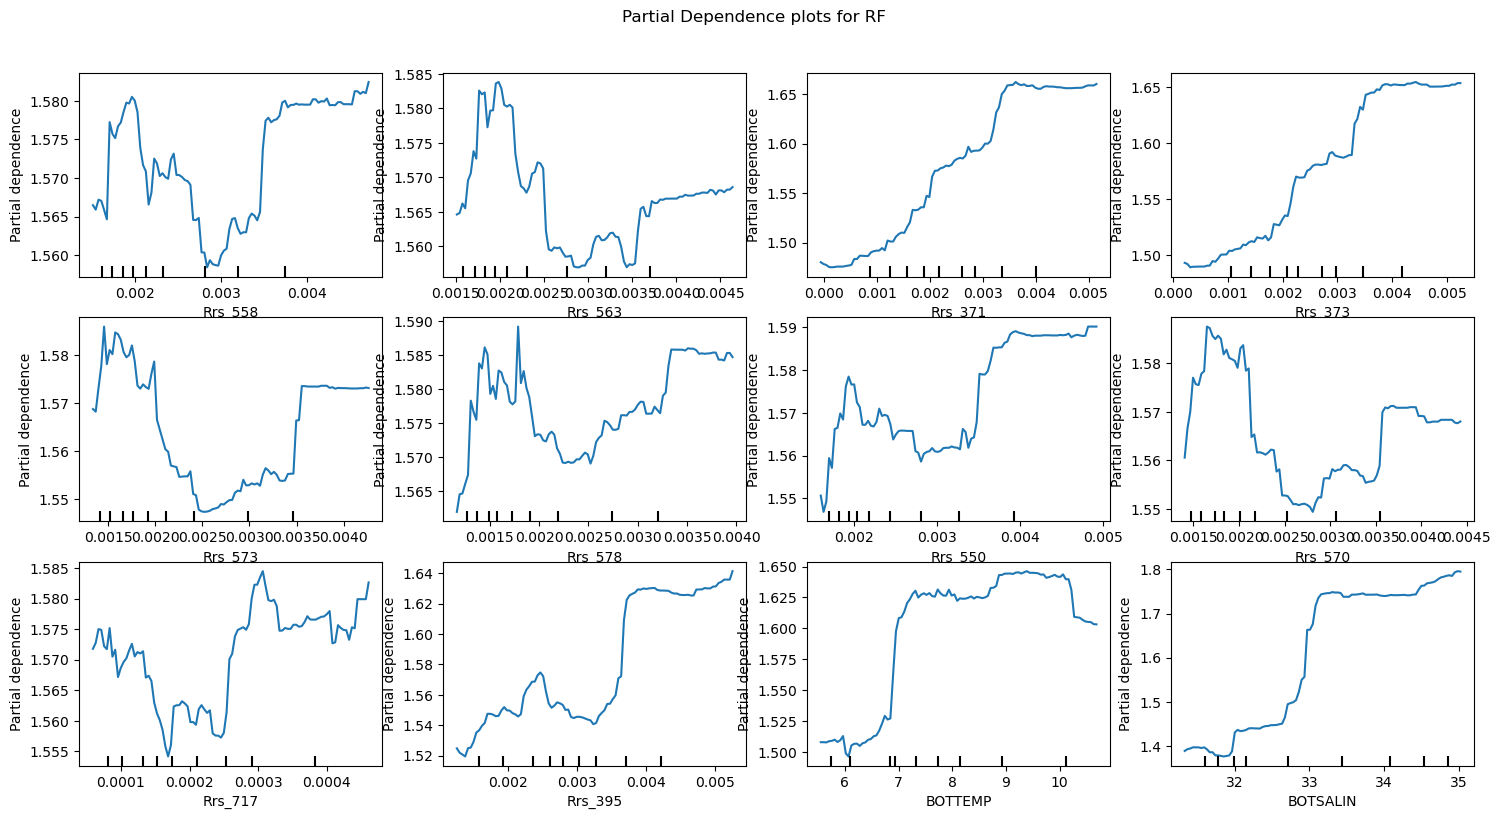

In [49]:
#RANDOM FOREST 
from sklearn.inspection import PartialDependenceDisplay
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 9))
# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten()

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    try: 
        PartialDependenceDisplay.from_estimator(
                            estimator=best_rf,
                            X=X_train_imputed,
                            features=[X_train_imputed.columns[i]],
                            target='EXPCATCHNUM',  
                            ax=ax
                        )
        #ax.set_title(f"{species}")
        ax.set_ylabel("Partial Dependence (log CPUE scale)")
    except IndexError:
        ax.remove()

fig.suptitle('Partial Dependence plots for RF',y=0.95)
plt.savefig('/home/jovyan/2026-proj-Trawling4PACE/figures/RF_PPD.jpg')

#### PPD: Boosted Regression Tree <a id="ppd_brt"></a>

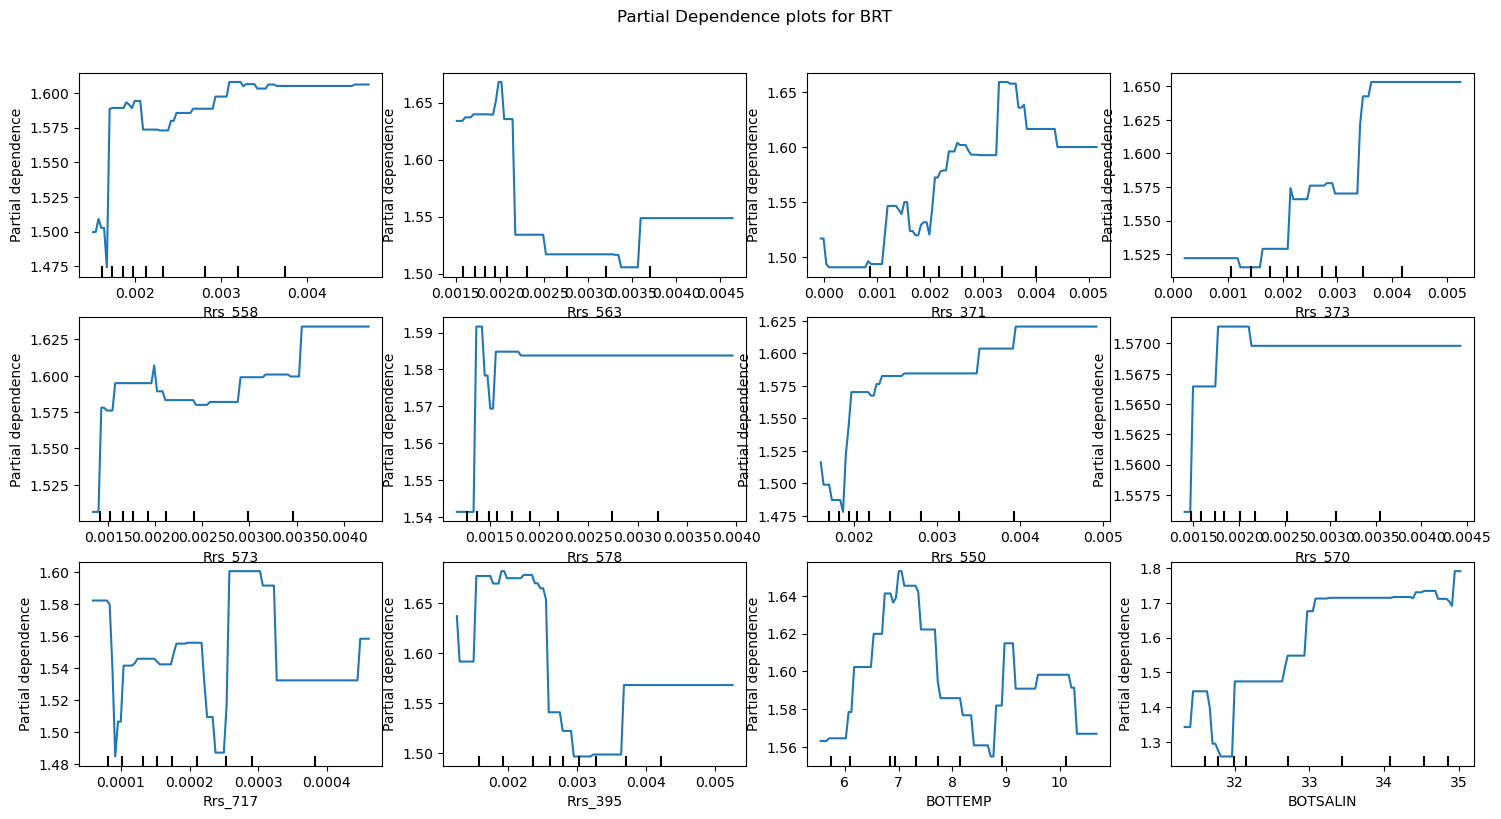

In [50]:
#BOOSTED REGRESSION TREE
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(18, 9))
# Flatten the axs array for easy iteration if needed, though direct indexing works too
axs = axs.flatten()

# Loop through each subplot and plot data
for i, ax in enumerate(axs):
    try: 
        PartialDependenceDisplay.from_estimator(
                            estimator=xgb_reg,
                            X=X_train_imputed,
                            features=[X_train_imputed.columns[i]],
                            target='EXPCATCHNUM',  
                            ax=ax
                        )
        #ax.set_title(f"{species}")
        ax.set_ylabel("Partial Dependence (log CPUE scale)")
    except IndexError:
        ax.remove()

fig.suptitle('Partial Dependence plots for BRT',y=.95)
plt.savefig('/home/jovyan/2026-proj-Trawling4PACE/figures/BRT_PPD.jpg')

#### Bland Altman Plots <a id="ba"></a>
Bland Altman plots are a graphical tool to assess agreement between two measurement techniques. The mean difference (bias) line is shown in red and the limit of agreement (LOA) lines are shown in dashed gray lines. A narrow range of LOA means predictions are close to the observations. A wide LOA range means that predictions vary a lot. If the points are scattered around zero, then the model error are stable. If there is a slope, then the error varies with catch size.

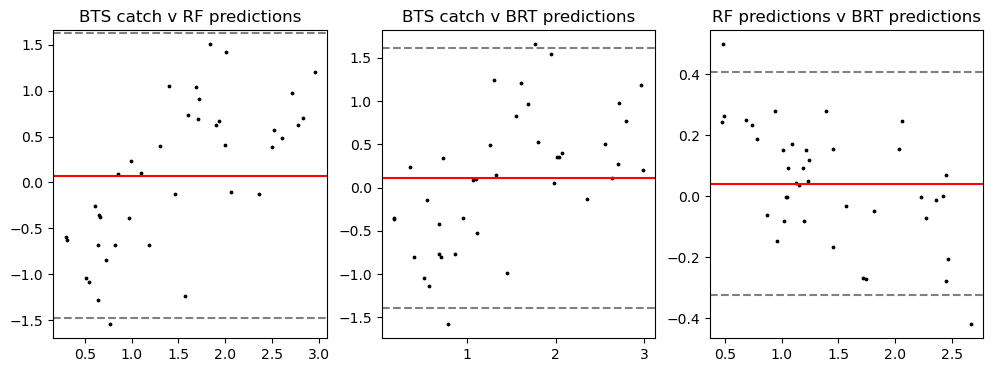

In [56]:
#Band Altman Plot
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) 
x=df.loc[y_test.index.tolist()].EXPCATCHNUM_log
y=predictions
differences= x-y
mean= (x+y)/2
ax1.scatter(mean, differences,s=3,c='black')
ax1.axhline(np.mean(differences), color='red', linestyle='-', label='Mean Diff')
ax1.axhline(np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--', label='Limits of agreement')
ax1.axhline(np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')
ax1.set_title('BTS catch v RF predictions')
#ax1.text(0.03, 0.12, f'N={len(x)}\nMAPE={((abs(x - y) / abs(x)).mean()*100).round(3)}', horizontalalignment='left', verticalalignment='center', transform=ax1.transAxes, fontsize=9)

x=df.loc[y_test.index.tolist()].EXPCATCHNUM_log
y=predictions_brt
differences= x-y
mean= (x+y)/2
ax2.scatter(mean, differences,s=3,c='black')
ax2.axhline(np.mean(differences), color='red', linestyle='-', label='Mean Diff')
ax2.axhline(np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--', label='Limits of agreement')
ax2.axhline(np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')
ax2.set_title('BTS catch v BRT predictions')

x=predictions
y=predictions_brt
differences= x-y
mean= (x+y)/2
ax3.scatter(mean, differences,s=3,c='black')
ax3.axhline(np.mean(differences), color='red', linestyle='-', label='Mean Diff')
ax3.axhline(np.mean(differences) + 1.96*np.std(differences), color='gray', linestyle='--', label='Limits of agreement')
ax3.axhline(np.mean(differences) - 1.96*np.std(differences), color='gray', linestyle='--')
ax3.set_title('RF predictions v BRT predictions')
plt.savefig('/home/jovyan/2026-proj-Trawling4PACE/figures/bland_altman.jpg')

## Visualize results <a id="vr"></a>
#### Mapped predicted abundance results <a id="mar"></a>

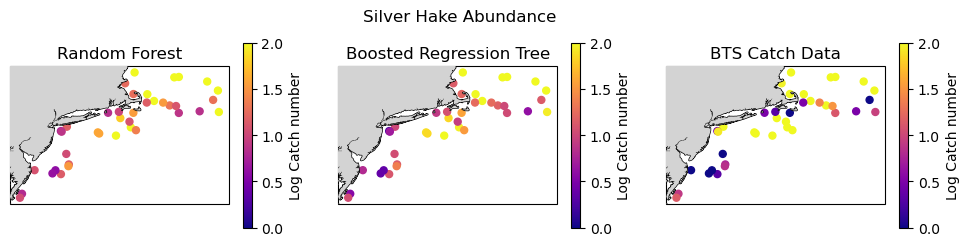

In [46]:
#VISUALIZE PREDICTED ABUNDANCE RESULTS
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, subplot_kw={'projection': cartopy.crs.PlateCarree()}, figsize=(12, 12))
im=ax1.scatter(df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLON, df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLAT, c=predictions,vmin=0,vmax=2,cmap='plasma',s=25)
ax1.set_title('Random Forest')
fig.colorbar(im, ax=ax1,shrink=0.2,label='Log Catch number')
ax1.add_feature(cartopy.feature.COASTLINE, linewidth=1)
ax1.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')

im1=ax2.scatter(df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLON, df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLAT, c=predictions_brt,vmin=0,vmax=2,cmap='plasma',s=25)
ax2.set_title('Boosted Regression Tree')
fig.colorbar(im1, ax=ax2,shrink=0.2,label='Log Catch number')
ax2.add_feature(cartopy.feature.COASTLINE, linewidth=1)
ax2.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')

im2=ax3.scatter(df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLON, df.loc[X_test_imputed.index.tolist()].DECDEG_ENDLAT, c=df.loc[y_test.index.tolist()].EXPCATCHNUM_log,cmap='plasma',vmin=0,vmax=2,s=25)
ax3.set_title('BTS Catch Data')
fig.colorbar(im2, ax=ax3,shrink=0.2,label='Log Catch number')
ax3.add_feature(cartopy.feature.COASTLINE, linewidth=1)
ax3.add_feature(cartopy.feature.LAND, zorder=100, facecolor='lightgrey')
fig.suptitle('Silver Hake Abundance', y=0.6)
plt.savefig('/home/jovyan/2026-proj-Trawling4PACE/figures/predictions_map.jpg',bbox_inches='tight',dpi=900)

#### Mapped residuals <a id="mr"></a>

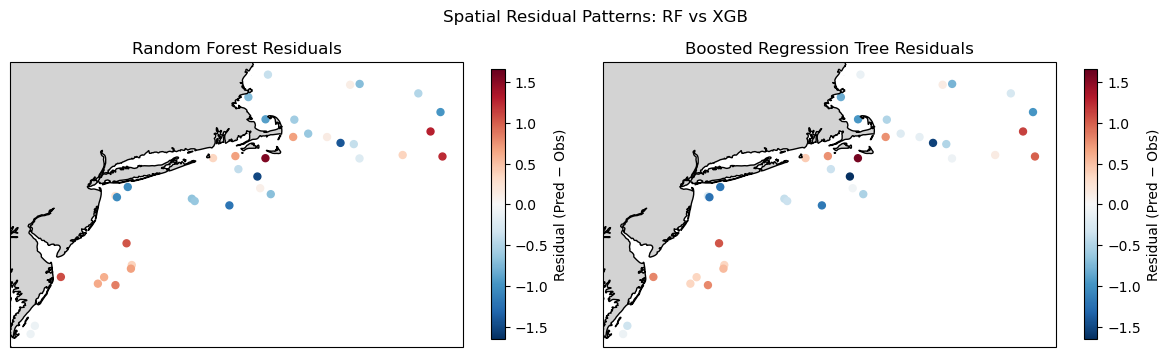

In [51]:
#compute residuals
import numpy as np

idx = X_test_imputed.index

obs = df.loc[y_test.index, 'EXPCATCHNUM_log']

rf_resid  = predictions      - obs
xgb_resid = predictions_brt  - obs

import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Index alignment
idx = X_test_imputed.index

# Coordinates
lons = df.loc[idx, 'DECDEG_ENDLON']
lats = df.loc[idx, 'DECDEG_ENDLAT']

# Observations
obs = df.loc[y_test.index, 'EXPCATCHNUM_log']

# Residuals
rf_resid  = predictions      - obs
xgb_resid = predictions_brt  - obs

# Symmetric color scale around zero
abs_max = np.nanmax(np.abs(np.concatenate([rf_resid, xgb_resid])))

fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 6),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# --- Random Forest residuals ---
sc1 = ax1.scatter(
    lons, lats,
    c=rf_resid,
    cmap='RdBu_r',
    vmin=-abs_max, vmax=abs_max,
    s=25,
    transform=ccrs.PlateCarree()
)
ax1.set_title('Random Forest Residuals')
ax1.add_feature(cfeature.COASTLINE, linewidth=1)
ax1.add_feature(cfeature.LAND, facecolor='lightgrey')
plt.colorbar(sc1, ax=ax1, shrink=0.5, label='Residual (Pred − Obs)')

# --- XGBoost residuals ---
sc2 = ax2.scatter(
    lons, lats,
    c=xgb_resid,
    cmap='RdBu_r',
    vmin=-abs_max, vmax=abs_max,
    s=25,
    transform=ccrs.PlateCarree()
)
ax2.set_title('Boosted Regression Tree Residuals')
ax2.add_feature(cfeature.COASTLINE, linewidth=1)
ax2.add_feature(cfeature.LAND, facecolor='lightgrey')
plt.colorbar(sc2, ax=ax2, shrink=0.5, label='Residual (Pred − Obs)')

fig.suptitle('Spatial Residual Patterns: RF vs XGB', y=0.8)
plt.tight_layout()
plt.savefig('/home/jovyan/2026-proj-Trawling4PACE/figures/residuals_map.jpg',bbox_inches='tight',dpi=900)
plt.show()


## Statistical analysis <a id="sa"></a>

In [55]:
from sklearn.model_selection import KFold
from scipy.stats import ttest_rel, wilcoxon
kf = KFold(n_splits=10, shuffle=True, random_state=42)

rf_errors = []
brt_errors = []

rf_rsquare = []
brt_rsquare = []

for train_idx, test_idx in kf.split(X):
    #X_train_scaled, X_test_scaled = X.iloc[train_idx], X.iloc[test_idx]
    X_train_scaled, X_test_scaled = X_train, X_test
    #y_train_scaled, y_test_scaled = y.loc[train_idx], y.loc[test_idx]
    y_train_scaled, y_test_scaled = y_train, y_test

    best_rf.fit(X_train_scaled, y_train_scaled)
    xgb_reg.fit(X_train_scaled, y_train_scaled, 
            eval_set=[(X_test_scaled, y_test_scaled)],
            verbose=False)

    rf_pred = best_rf.predict(X_test_scaled)
    brt_pred = xgb_reg.predict(X_test_scaled)

    rf_rmse = np.sqrt(mean_squared_error(y_test_scaled, rf_pred))
    brt_rmse = np.sqrt(mean_squared_error(y_test_scaled, brt_pred))

    rf_r2 = r2_score(y_test_scaled, rf_pred)
    brt_r2 = r2_score(y_test_scaled, brt_pred)
    
    rf_errors.append(rf_rmse)
    brt_errors.append(brt_rmse)
    rf_rsquare.append(rf_r2)
    brt_rsquare.append(brt_r2)


w_stat, p_value = wilcoxon(rf_errors, brt_errors)
print("Wilcoxon p-value:", p_value)

t_stat, p_value = ttest_rel(rf_rsquare, brt_rsquare)
print("Paired t-test p-value:", p_value)

print("Mean RF RMSE :", np.mean(rf_errors))
print("Mean BRT RMSE:", np.mean(brt_errors))
print("Mean diff (RF - BRT):", np.mean(np.array(rf_errors) - np.array(brt_errors)))

print("Mean RF R2 :", np.mean(rf_rsquare))
print("Mean BRT R2:", np.mean(brt_rsquare))

Wilcoxon p-value: 0.001953125
Paired t-test p-value: 0.0
Mean RF RMSE : 0.807835311451122
Mean BRT RMSE: 0.7643010061853129
Mean diff (RF - BRT): 0.04353430526580915
Mean RF R2 : 0.4548518947400401
Mean BRT R2: 0.5120248524519122


/srv/conda/envs/notebook/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:423: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return hypotest_fun_in(*args, **kwds)


## Conclusions <a id="conc"></a>
The BRT performed better than the RF model, with a higher R2 value and lower RMSE, though not by a huge margin. There was a statistical difference between the results from both models, although the predictions from both models were similar. <br>
Overall, this model could be improved with more catch data for silver hake. We had 3 BTS surveys to use that overlapped with the PACE timeframe, though we had to drop many catch observations due to cloud cover during the PACE overpass. The BTS dataset is growing as the survey is conducted twice a year - this analysis may be improved by including more catch data. <br>
If we had time, we would have loved to test other species, test other models (like a neural network), incorporate more catch data (through commercial fishing data or additional research surveys), and explore the addition of different variables (like the PACE MOANA product) 